# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis

import pywt
# variável para usar ou não wavelet
wavelet = False

from calcula_descritores import calculate_statistics
from calcula_metricas import calculate_metrics

# <span style="font-size: 36px;"> Modelo de classificação baseado em SVM </span>
---

## <span style="font-size: 28px;"> Extraindo e preparando os dados </span>

In [3]:
# Caminho relativo para o arquivo 'mat_vibration.mat'
caminho_arquivo = "C:\\Users\\Mathe\\projetos\\IC-ml-manutencao-preditiva-rolamentos-IFES\\Dados\\mat_classes.mat"

# Carregar o arquivo .mat
data = sio.loadmat(caminho_arquivo)

X = data['classes'][:, :2560]
y = data['classes'][:, 2560]

# Dividir o conjunto de dados em treino e teste (mantendo a mesma proporção de classes em ambos)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

## <span style="font-size: 28px;"> Obtendo descritores estatísticos </span>

,Classe,Precision,Recall,Accuracy,Specificity,F1 Score
0,1,1.000000,1.000000,1.000000,1.000000,1.000000
1,2,1.000000,1.000000,1.000000,1.000000,1.000000
2,3,0.866667,0.866667,0.973333,0.985185,0.866667
3,4,1.000000,1.000000,1.000000,1.000000,1.000000
4,5,1.000000,1.000000,1.000000,1.000000,1.000000
5,6,1.000000,1.000000,1.000000,1.000000,1.000000
6,7,0.866667,0.866667,0.973333,0.985185,0.866667
7,8,1.000000,1.000000,1.000000,1.000000,1.000000
8,9,0.906250,0.966667,0.986667,0.988889,0.935484
9,10,0.964286,0.900000,0.986667,0.996296,0.931034


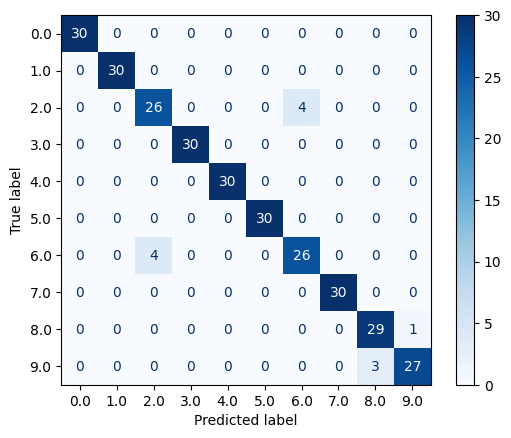

In [10]:
# Calcular os descritores estatísticos dos sinais de vibração do conjunto de treino e teste
descrX_train = calculate_statistics(X_train)
descrX_test = calculate_statistics(X_test)

# Treina o modelo SVM
scaler = StandardScaler()
scaled_descrXtrain = scaler.fit_transform(descrX_train)
mdl_svm = SVC(kernel='rbf', C=1)
mdl_svm.fit(scaled_descrXtrain, y_train)

# Valida o modelo usando Cross-Validation
cv_svm = cross_val_score(mdl_svm, scaled_descrXtrain, y_train, cv=5)

# Realiza o teste
scaled_descrXtest = scaler.transform(descrX_test)
y_pred = mdl_svm.predict(scaled_descrXtest)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)

# Métricas de Desempenho
precision, recall, accuracy, specificity, f1score, df = calculate_metrics(cm)
df


## <span style="font-size: 28px;"> Treino do Modelo </span>

,Classe,Precision,Recall,Accuracy,Specificity,F1 Score
0,1,1.000000,0.971429,0.996667,1.000000,0.985507
1,2,0.952381,1.000000,0.996667,0.996429,0.975610
2,3,0.846154,0.891892,0.966667,0.977186,0.868421
3,4,1.000000,1.000000,1.000000,1.000000,1.000000
4,5,1.000000,0.958333,0.996667,1.000000,0.978723
5,6,0.970588,1.000000,0.996667,0.996255,0.985075
6,7,0.857143,0.800000,0.966667,0.985185,0.827586
7,8,0.958333,1.000000,0.996667,0.996390,0.978723
8,9,0.964286,0.931034,0.990000,0.996310,0.947368
9,10,0.971429,0.971429,0.993333,0.996226,0.971429


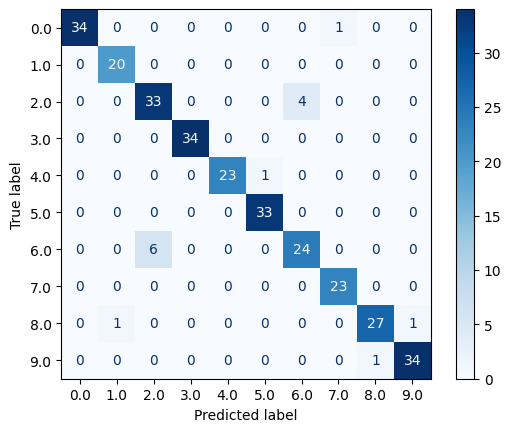

In [7]:
wavelet_name = 'db4'
level = 3

# Captura dimensões dos dados
n_samples, n_features = X.shape

# O level máximo de escalonamento que essa configuração de wavelet permite para os dados em questão
max_level = pywt.dwt_max_level(n_features, wavelet_name)

if level <= max_level:

    # Decompor os sinais usando a wavelet escolhida e o nível de decomposição
    mat_coeficientes_wavelet = []
    for i in range(n_samples):
        coeffs = pywt.wavedec(X[i, :], wavelet_name, level=level)  # Correção aqui
        flattened_coeffs = np.concatenate(coeffs)
        mat_coeficientes_wavelet.append(flattened_coeffs)
    arr_coeficientes_wavelet = np.array(mat_coeficientes_wavelet)

    # Dividir os dados em treinamento e teste (70% treinamento, 30% teste)
    X_train, X_test, y_train, y_test = train_test_split(arr_coeficientes_wavelet, y, test_size=0.3, random_state=42)

    # Calcular os descritores estatísticos dos sinais de vibração do conjunto de treino e teste
    descrX_train = calculate_statistics(X_train)
    descrX_test = calculate_statistics(X_test)

    # Treina o modelo SVM
    scaler = StandardScaler()
    scaled_descrXtrain = scaler.fit_transform(descrX_train)
    mdl_svm = SVC(kernel='rbf', C=1)
    mdl_svm.fit(scaled_descrXtrain, y_train)

    # Valida o modelo usando Cross-Validation
    cv_svm = cross_val_score(mdl_svm, scaled_descrXtrain, y_train, cv=5)

    # Realiza o teste
    scaled_descrXtest = scaler.transform(descrX_test)
    y_pred = mdl_svm.predict(scaled_descrXtest)

    # Gerar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap=plt.cm.Blues)

    # Métricas de Desempenho
    precision, recall, accuracy, specificity, f1score, df = calculate_metrics(cm)
    df

else:
    print(f'O nível máximo de decomposição é {max_level}')

df